In [326]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import paleogeography as pg
from sphere_tools import random_points_on_sphere

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker


%matplotlib inline

desampling = 2

#topo_smoothX,topo_smoothY,topo_smoothZ = pg.load_netcdf('../paleogeography/paleotopobathy_smooth.nc')
topo_smoothX,topo_smoothY,topo_smoothZ = pg.load_netcdf('../paleogeography/paleotopo_grids/paleotopobathy_smooth_101.50Ma.nc')

topo = topo_smoothZ[::desampling,::desampling]
gridX = topo_smoothX[::desampling]
gridY = topo_smoothY[::desampling]


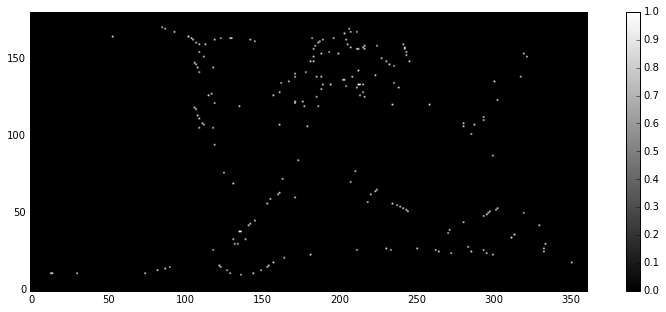

In [175]:
#outlet_longs,outlet_lats = random_points_on_sphere(5000)

#plt.plot(outlet_longs,outlet_lats,'.')

outlets = (topo>-150) & (topo<-135)

local_maxi2 = peak_local_max(outlets, indices=False, footprint=np.ones((3, 3)))
markers2 = ndi.label(local_maxi2)[0]

plt.figure(figsize=(14,5))
plt.imshow(markers2,cmap=plt.cm.gray,vmax=1,origin='lower')
plt.colorbar()

(array([ 10,  10,  10, ..., 179, 179, 179]), array([  0,   1,   2, ..., 358, 359, 360]))


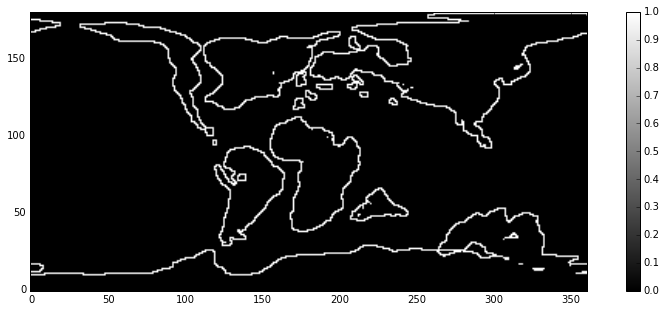

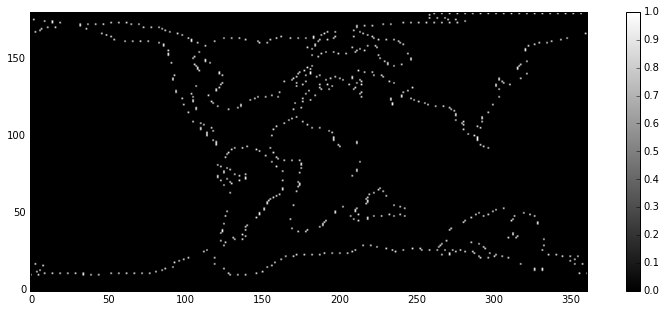

In [180]:
land_mask = topo<0.

distance_to_land = ndi.distance_transform_edt(land_mask)

outlets = (distance_to_land>0) & (distance_to_land<1.5)

plt.figure(figsize=(14,5))
plt.imshow(outlets,cmap=plt.cm.gray,origin='lower')
plt.colorbar()

indices = np.where(outlets)
print indices

outlets2 = np.zeros(outlets.shape)
outlets2[indices[0][::5],indices[1][::5]] = 1

plt.figure(figsize=(14,5))
plt.imshow(outlets2,cmap=plt.cm.gray,origin='lower')
plt.colorbar()

local_maxi2 = peak_local_max(outlets2, indices=False, footprint=np.ones((3, 3)))
markers2 = ndi.label(local_maxi2)[0]


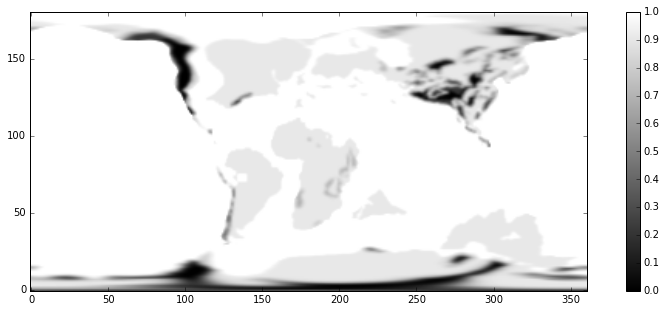

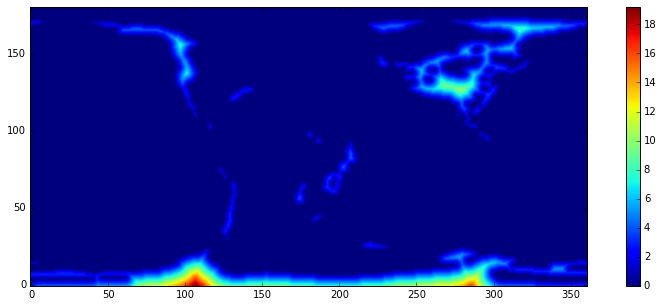

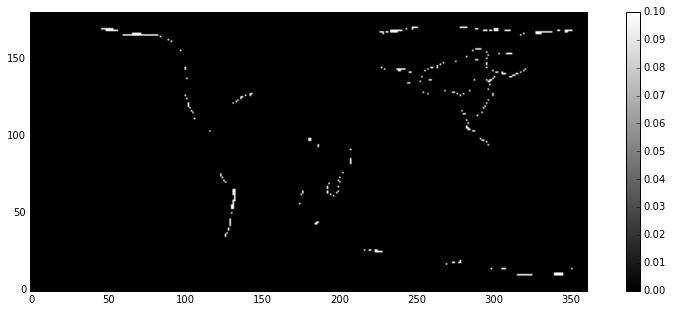

In [171]:

norm_topo = topo-np.min(topo)
norm_topo = norm_topo/np.max(norm_topo)


#image[image>100.] = 0.
image = -topo
image[image>100.] = 100.
image = image-np.min(image)
image = image/np.max(image)


plt.figure(figsize=(14,5))
plt.imshow(image, cmap=plt.cm.gray, origin='lower')
plt.colorbar()
plt.show()


distance = ndi.distance_transform_edt(image<0.9)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)))
markers = ndi.label(local_maxi)[0]

plt.figure(figsize=(14,5))
plt.imshow(distance, cmap=plt.cm.jet,origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(markers, cmap=plt.cm.gray,origin='lower',vmax=0.1)
plt.colorbar()
plt.show()



In [195]:
#labels1 = watershed(norm_topo, markers)
labels1 = watershed(norm_topo, markers2)
labels1[mask] = -1

#labels2 = random_walker(norm_topo, markers, mode='cg') #, beta=130, mode='bf', tol=0.001, return_full_prob=False, spacing=None)
labels2 = random_walker(-distance, markers2, mode='bf', beta=130) #, beta=130, mode='bf', tol=0.001, return_full_prob=False, spacing=None)
labels2[mask] = -1

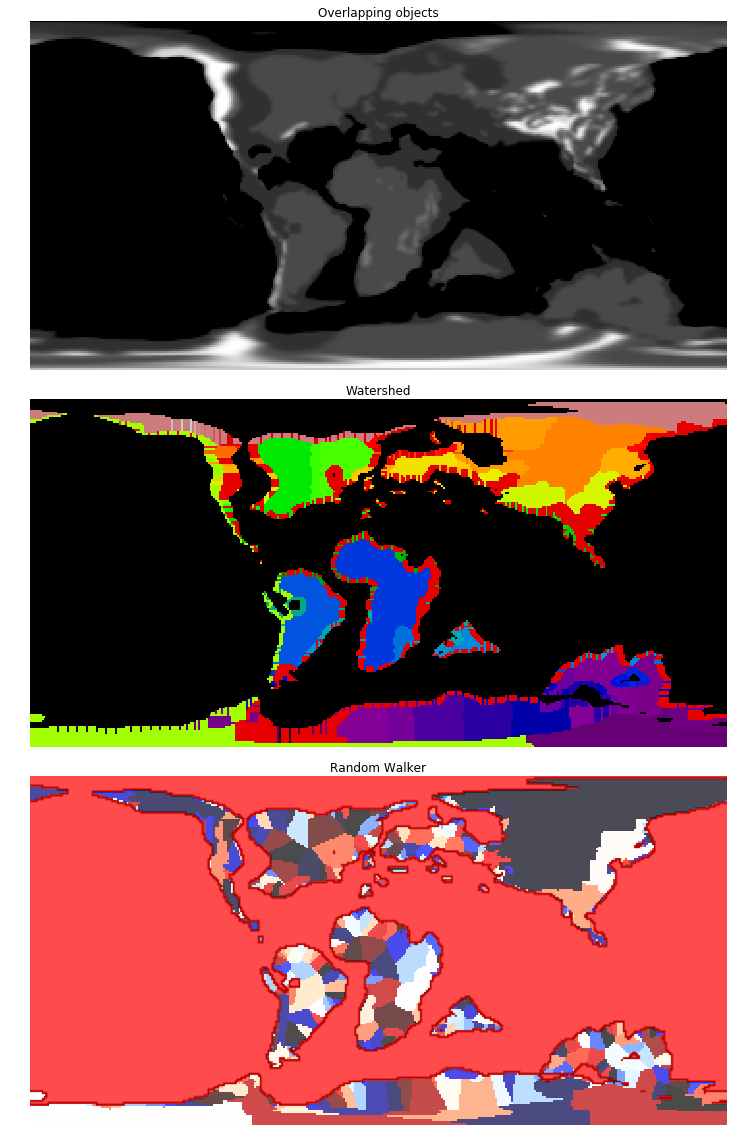

In [196]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 16), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(topo, cmap=plt.cm.gray, interpolation='nearest',vmin=-1000)
ax[0].set_title('Overlapping objects')
ax[1].imshow(labels1, cmap=plt.cm.spectral, interpolation='nearest',origin='lower')
ax[1].set_title('Watershed')
ax[2].imshow(labels2, cmap=plt.cm.flag, interpolation='nearest',origin='lower')
ax[2].imshow(outlets,cmap=plt.cm.gray_r,origin='lower',alpha=0.3)
ax[2].set_title('Random Walker')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


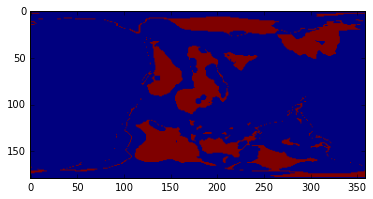

(64261,)
[False False False ..., False False False]
64261


/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide


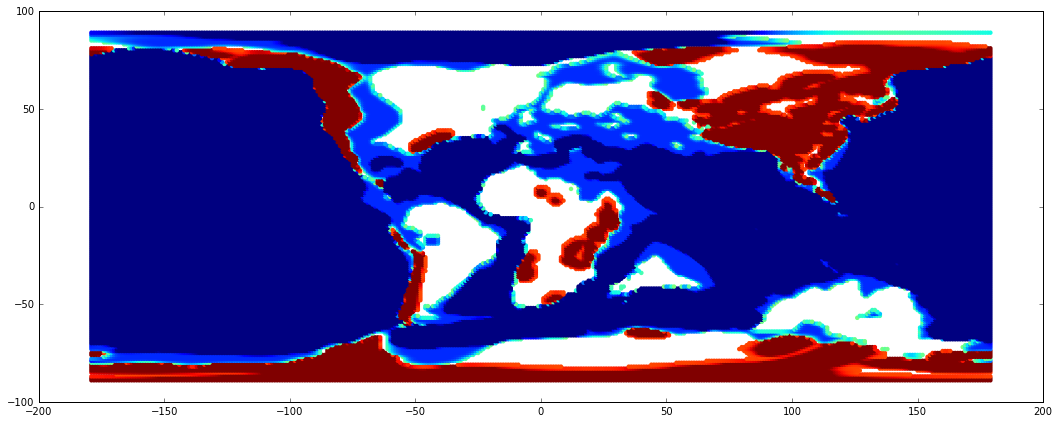

In [327]:
import inpaint
from sphere_tools import sampleOnSphere

#tmp = topo


topo_masked = np.copy(topo)[1:-1,1:-1]

lowland_mask = (topo_masked>0.) & (topo_masked<201.)
topo_masked[lowland_mask] = np.nan

plt.imshow(lowland_mask)
plt.show()

#topo_fill = inpaint.fill_crystalgrowth(topo,invalid=lowland_mask)

coordsX,coordsY = np.meshgrid(gridX[1:-1],gridY[1:-1])

coordsX = coordsX.flatten()
coordsY = coordsY.flatten()

coordsXm = coordsX[np.invert(lowland_mask).flatten()]
coordsYm = coordsY[np.invert(lowland_mask).flatten()]
coordsTopom = topo_masked.flatten()[np.invert(lowland_mask).flatten()]

d,l = sampleOnSphere(coordsYm,coordsXm,coordsTopom,
                     coordsY,coordsX,k=8)
w = 1./d**2
coordsTopo = np.sum(w * coordsTopom.ravel()[l],axis=1) / np.sum(w,axis=1)

print coordsX.shape
print lowland_mask.flatten()
print 179*359

plt.figure(figsize=(18,7))
#plt.imshow(lowland_mask)
plt.scatter(coordsXm,coordsYm,c=coordsTopom,edgecolors='',
            vmin=-300,vmax=300)
#plt.imshow(topo_fill,origin='lower',vmin=-200,vmax=500)
#plt.colorbar()

#plt.figure(figsize=(18,7))
#plt.imshow(lowland_mask)
#plt.scatter(coordsX,coordsY,c=coordsTopo,edgecolors=''
#            ,vmin=-300,vmax=300)



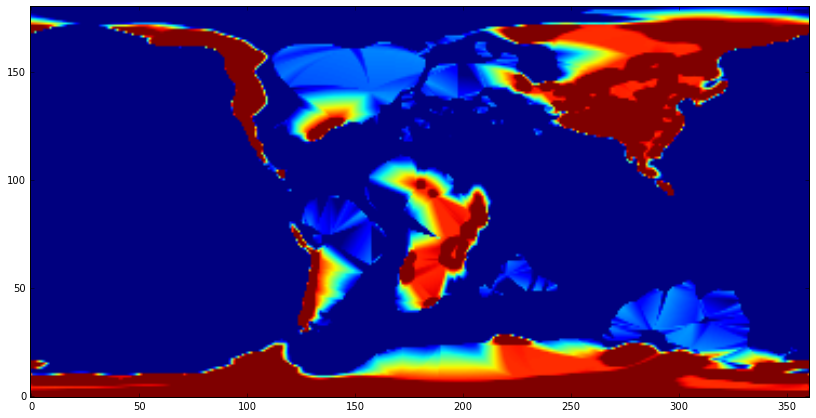

In [341]:
import os
def write_xyz_file(output_filename, output_data):
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')
            
write_xyz_file('tmp.xyz',zip(coordsXm.tolist(),coordsYm.tolist(),coordsTopom.tolist()))


os.system('gmt sphinterpolate tmp.xyz -I1d -R-180/180/-90:00/90:00 -Q0 -Gtmp.nc -T1 -V')

tX,tY,tZ = pg.load_netcdf('tmp.nc')

plt.figure(figsize=(18,7))
plt.imshow(tZ,origin='lower',vmin=-100,vmax=250)
